In [ ]:
!pip install pandas nltk matplotlib nrclex pandarallel swifter

In [11]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
import matplotlib.pyplot as plt
from pandarallel import pandarallel
import swifter
import time
from tqdm import tqdm

# Download necessary resources
nltk.download('vader_lexicon')

nltk.download('punkt_tab')
# # Load dataset (Replace with your actual file path)
file_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Reviews.csv"
df = pd.read_csv(file_path)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [25]:
df = pd.read_csv(file_path)

In [29]:

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Initialize parallel processing
pandarallel.initialize(progress_bar=True)

# Function for sentiment analysis with a progress bar
def get_sentiment_with_progress(df):
    tqdm.pandas(desc="Processing Sentiment")  # Enable tqdm progress bar
    return df["Text"].progress_apply(lambda text: sia.polarity_scores(str(text))["compound"])

# Apply Sentiment Analysis using tqdm progress bar
df["Sentiment"] = get_sentiment_with_progress(df)
df["Sentiment"] = df["Sentiment"].apply(lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral"))


# Apply Emotion Analysis on a **smaller subset** for speed
sample_size = min(10000, len(df))  # Limit NRCLex to 10,000 rows
df_sample = df.sample(n=sample_size, random_state=42)


INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Processing Sentiment: 100%|██████████| 570878/570878 [10:52<00:00, 875.35it/s] 


In [40]:

# Function for emotion analysis with progress tracking
def get_emotions(text):
    emotions = NRCLex(str(text)).affect_dict
    # print(emotions)
    emotion_counts = {}
    for emotion_list in emotions.values():  # Iterate over list of emotions
        for emotion in emotion_list:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
    return {key: value / len(emotions.values())  for key, value in emotion_counts.items()}

In [43]:

# Apply tqdm progress bar for emotion analysis
tqdm.pandas(desc="Processing Emotions")
df_sample["Emotions"] = df_sample["Text"].progress_apply(get_emotions)

# Merge results back to main dataset
# drop column Emotions from df
df.drop(columns=["Emotions"], inplace=True)
df = df.merge(df_sample[["Text", "Emotions"]], on="Text", how="left")

Processing Emotions: 100%|██████████| 10000/10000 [00:14<00:00, 683.44it/s]


| Sentiment   | Emotions                                                                                                                                                                                                                                                                                                                  | Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

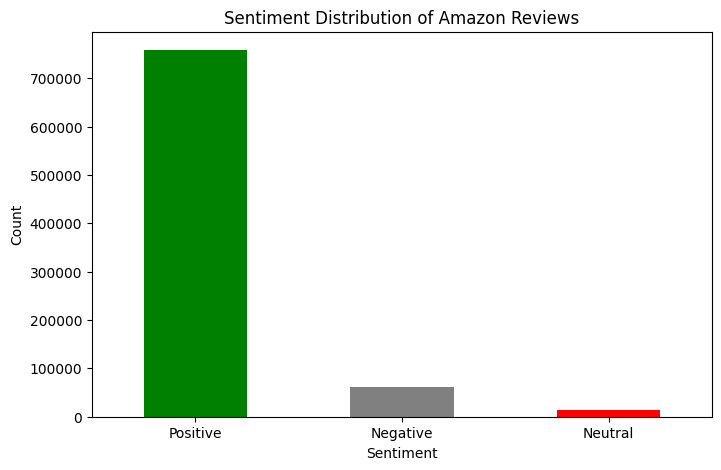

In [45]:

# Display first few rows
print(df[["Sentiment", "Emotions", "Text"]].head(15).to_markdown(index=False))

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
df["Sentiment"].value_counts().plot(kind="bar", color=["green", "gray", "red"])
plt.title("Sentiment Distribution of Amazon Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()